# Plot Label Bounding Boxes

This is a helper script containing simple methods for ploting the label bounding boxes on the X-Ray chest images.

In the first place we are going to load the x-ray images, then load the csv file containing the labels, and finally put it all together in the same plot.
If you are new to python I recommend you follow the steps, but if you have quite some experience just jump straight to the last method!

See the final result:


### Plot all the anotations corresponding to the same image

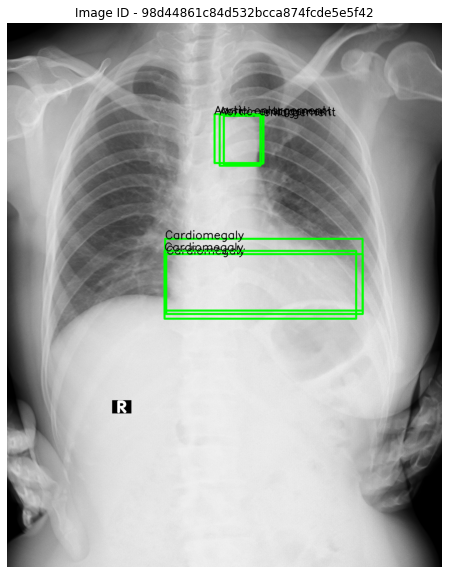

In [ ]:
# Imports
import os
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import pandas as pd
!pip install opencv-python
import cv2

## Importing the data

The *data_importer* method is used to get a list with the directories of all the images within a directory.

**Parameters**: 
* directory: path where the test and training directories are located
* dataset: "train" for trainin data, "test" for test data

* it returns a list of strings containing the paths where the images are located

In [ ]:
# Get a list with all the image paths. The dataset parameter defines if you want to load training or test images.
def data_importer(directory, dataset):
    list_directories = []
    for dirname, _, filenames in os.walk(directory):
        if dirname.split("/")[-1] == dataset: 
            for filename in filenames:
                list_directories.append(os.path.join(dirname, filename))
        
    return list_directories


This is how the method is called:

In [ ]:
dataset_directory = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection'

train_paths = data_importer(dataset_directory,"train")

print("Total files found: ", len(train_paths))

## Importing dicom data

The *read_xray* function will help us to load dicom image data as np.arrays, this will allow us to work in a more confortable way with images and compute operations more efficiently. This function is taken from the notebook https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way


In [ ]:
# Read dicom data into np.array

def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


Now we can see how a sample image looks like

In [ ]:
# Read one image to check the loading is OK
img = read_xray(train_paths[0])
plt.figure(figsize = (10,10))
plt.imshow(img, 'gray')
plt.axis("Off")

## Load the annotation data

In this challenge, the annotation data is provided in the train.csv file. To be able to work with it first we need to load it as a dataframe (df). For that I will use pandas dataframe.

In [ ]:
# Create a dataframe containing the training data
csv_path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv'
df = pd.read_csv(csv_path)

In [ ]:
# Getting the first 5 elements of the dataframe
df.head()

From the loaded dataframe we are going to use the information stored in the **class_name** column to label the detection bounding box.

Then, we are going to use the **x_min** and **y_min** values to determine the upper left corner of the annotation bounding box, and the **x_max** and **y_max** to place the lower right corner of the bounding box.

## Plot the annotations

**This are the important methods!!**

First let's plot the annotations just one by one, one dataframe item at a time

The method *plot_annotations* has as input:
* df_item: a dataframe item
* path: the image dataset path
* hide_axis: a boolean to state whether to plot the image axis
* predicted_df_item: second dataframe item in case the user wants to compare two annotations on the first item's image.

This method will come handy at any point of the process as it will allow us to visilize the annotations on top of the image, and compare the predictions with the ground truths.

## Plot one annotation


In [ ]:
# method to plot images with its annotations
def plot_annotations(df_item, path, hide_axis = False, predicted_df_item = None):
    
    # Convert the x-ray image into RGB
    img = cv2.cvtColor(read_xray(os.path.join(path, "{}.dicom".format(df_item["image_id"]))),cv2.COLOR_GRAY2RGB)
    
    if (np.isnan(df_item["x_min"]) and np.isnan(df_item["y_min"])):
        return print("No detection found!")
    
    # Declare coordinates and convert them to integers
    x_min = int(df_item["x_min"])
    y_min = int(df_item["y_min"])
    x_max = int(df_item["x_max"])
    y_max = int(df_item["y_max"])

    # Create figure
    plt.figure(figsize = (10,10))
    
    # Create rectangle where the annotation is located
    image = cv2.rectangle(img=img,rec=(x_min,y_min,x_max-x_min,y_max-y_min), color = (0,255,0),thickness = 10)
    
    # Add label to the annotation
    image = cv2.putText(image, df_item["class_name"], (int(df_item["x_min"]),int(df_item["y_min"])), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)
    
    if predicted_df_item is not None:
        
        if not ((np.isnan(predicted_df_item["x_min"])) and (np.isnan(predicted_df_item["y_min"]))):

            # Declare coordinates and convert them to integers
            pred_x_min = int(predicted_df_item["x_min"])
            pred_y_min = int(predicted_df_item["y_min"])
            pred_x_max = int(predicted_df_item["x_max"])
            pred_y_max = int(predicted_df_item["y_max"])

            # Create rectangle where the annotation is located
            image = cv2.rectangle(img=img,rec=(pred_x_min,pred_y_min,pred_x_max-pred_x_min,pred_y_max-pred_y_min), color = (0,0,255),thickness = 10)

            # Add label to the annotation
            image = cv2.putText(image, "pred: {}".format(predicted_df_item["class_name"]), (int(predicted_df_item["x_min"]),int(predicted_df_item["y_min"])), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)
        else:
            print("No detection found for prediction!")
                
    # Plot image
    plt.imshow(image)
    
    # Select if axis should be hidden
    if hide_axis:
        plt.axis("Off")
    plt.show()
    

In [ ]:
# Plot the 3rd dataset item

train_directory = os.path.join(dataset_directory, "train")
plot_annotations(df.iloc[3],train_directory, True)

In [ ]:
# Compare the 3rd dataset item with the 2nd

train_directory = os.path.join(dataset_directory, "train")
plot_annotations(df.iloc[3],train_directory, True,df.iloc[2])

## Plot all the anotations corresponding to the same image

This is the method we have all waited for!!

The *plot_all_labels* method will allow us to plot several annotations corresponding to the same x-ray in the same image. 

For that, we need to extract the all the the labels corresponding to each image.

With the *.unique()* call we are obtaining the unique image ids from the dataframe. Next, using the *.isin()* method we are getting all the annotations corresponding to one exact image.

In [ ]:
# Get the image ids without repetitions
image_ids = df.image_id.unique()

# Select all annotations corresponding to the first image
image_annotations = df.loc[df['image_id'].isin([image_ids[52]])]

image_annotations

The method *plot_all_labels* has as input:
* df_item: is the dataframe containing al the annotations corresponding to one image, in this case image_annotations
* path: as before, the path where we can find the images as a string
* hide_axis: a boolean determining if we want to hide or show the image axis

and outputs the plot containing all the annotations

In [ ]:
# method to plot images with its annotations
def plot_all_labels(df_item, path, hide_axis = False):
    # Convert the x-ray image into RGB
    image = cv2.cvtColor(read_xray(os.path.join(path, "{}.dicom".format(df_item.iloc[1]["image_id"]))),cv2.COLOR_GRAY2RGB)
    
    # Create figure
    plt.figure(figsize = (10,10))
    plt.title("Image ID - {}".format(df_item.iloc[1]["image_id"]))
    
    for index,item in df_item.iterrows():
        
        if (np.isnan(item["x_min"]) and np.isnan(item["y_min"])):
            continue

        # Declare coordinates and convert them to integers
        x_min = int(item["x_min"])
        y_min = int(item["y_min"])
        x_max = int(item["x_max"])
        y_max = int(item["y_max"])

        # Create rectangle where the annotation is located
        image = cv2.rectangle(img=image,rec=(x_min,y_min,x_max-x_min,y_max-y_min), color = (0,255,0),thickness = 10)

        # Add label to the annotation
        image = cv2.putText(image, item["class_name"], (int(item["x_min"]),int(item["y_min"])), cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=(0,0,0), thickness=3)

                
    # Plot image
    plt.imshow(image)
    
    # Select if axis should be hidden
    if hide_axis:
        plt.axis("Off")
    plt.show()

**And here you have the call to the function, *voilà*!**

This is an easy method to plot the images with it's corresponding segmentations. If you would like to beautify it just plaz with the font, thickness and color of the functions [cv2.putText()](https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/) and [cv2.rectangle()](https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method/). Have linked the documentation.

In [ ]:
plot_all_labels(image_annotations, train_directory, hide_axis = True)